<a href="https://colab.research.google.com/github/SydanJainen/Cell-image-segmentation/blob/main/image_Segmantation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CELL IMAGE SEGMENTATION

## HYPERPARAMETER


In [1]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNEL = 3

BATCH_SIZE = 16
EPOCHS = 60
PADDING = 0
STRIDE = 1
PATIENCE = 5

VAL_SPLIT = 0.3
SEED = 24

LEARNING_RATE = 1e-2#1e-4
EPS = 1e-3
CHECKPOINT_PATH = 'unet_chckpnt.pth.tar'

width_out = 256
height_out = 256

## CHECK IF COLAB OR OFFLINE

In [2]:
if 'google.colab' in str(get_ipython()):
  isColab = True
else:
  isColab = False

## CHECK IF GPU IS AVAILABLE

In [3]:
import torch

num_gpu = torch.cuda.device_count()
print(f'{num_gpu} GPU available')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

1 GPU available


## REQUIREMENT

In [4]:
if isColab:
  import os
  from google.colab import files, drive
  if (not 'kaggle.json' in os.listdir()):
    print("Upload kaggle.json")
    files.upload()
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
  drive.mount('/content/drive')
  DB_PATH = '/content/drive/MyDrive/scuola/deeplife/'
else:
  print("Check if folder is correct")
  DB_PATH = 'database/'

Check if folder is correct


## IMPORTS

In [5]:
if isColab:
    !pip install opencv-python
    !pip install tqdm

In [6]:
import os
import sys
import glob
import tqdm
import json
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import cv2
from cv2 import imwrite
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as F
from sklearn.model_selection import train_test_split
import albumentations as A

In [7]:
# aplly SEED to all random functions
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [8]:
if os.path.exists(DB_PATH):
    print("Database folder found")
else:
    print(" Generate the database")
    os.makedirs(DB_PATH)
    os.chdir(DB_PATH)
    if(isColab):
        !pip install kaggle
        !kaggle competitions download -c data-science-bowl-2018
        !unzip -q data-science-bowl-2018.zip -d ./
        !unzip -q cellular-segmentation/stage1_train.zip -d unpreocessed/
        if os.path.exists('./cellular-segmentation') and os.path.exists('./data-science-bowl-2018.zip'):
            !rm data-science-bowl-2018.zip
    else:
        print("Download the database and place it in the folder")
    os.chdir('..')

Database folder found


In [9]:
IMAGE_PATH = os.path.join(DB_PATH, "train")
LABEL_PATH = os.path.join(DB_PATH, "label")

# Ensure both directories have the same number of files
number_images = len(os.listdir(IMAGE_PATH))
number_labels = len(os.listdir(LABEL_PATH))

assert number_images == number_labels

# LOAD PIL IMAGES AND LABELS
image_files = sorted(os.listdir(IMAGE_PATH))
label_files = sorted(os.listdir(LABEL_PATH))

# Split into train and temp sets
train_images, val_images, train_labels, val_labels = train_test_split(image_files, label_files, test_size=VAL_SPLIT, random_state=SEED)


In [10]:
# Get and resize train images and masks
x_train = np.zeros((number_images, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL), dtype=np.uint8)
y_train = np.zeros((number_labels, height_out, width_out, 1))
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for length in tqdm.tqdm(range(number_images)):
    img = cv2.imread(IMAGE_PATH + '/' + image_files[length])
    x_train[length] = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)

    mask = cv2.imread(LABEL_PATH + '/' + label_files[length], cv2.IMREAD_GRAYSCALE)
    y_train[length] = cv2.resize(mask, (width_out, height_out), interpolation=cv2.INTER_AREA).reshape(height_out, width_out, 1)

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [00:00<00:00, 752.47it/s]

Done!


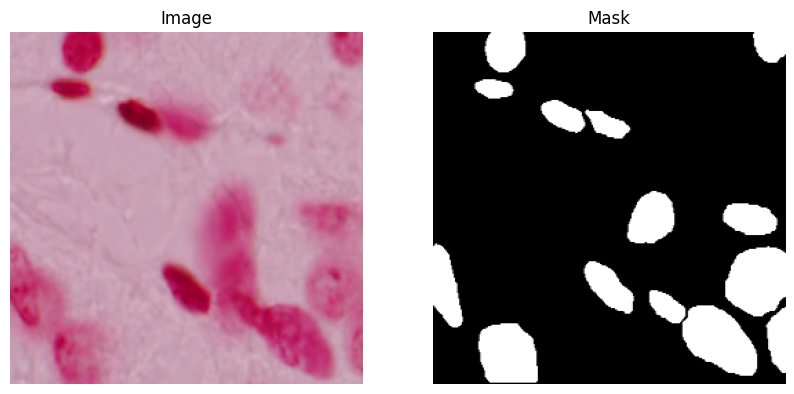

In [11]:
# draw random sample from the dataset

def draw_sample(x, y):
    idx = random.randint(0, len(x)-1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(x[idx])
    ax[0].set_title('Image')
    ax[0].axis('off')
    ax[1].imshow(y[idx].squeeze(), cmap='gray')
    ax[1].set_title('Mask')
    ax[1].axis('off')
    plt.show()

draw_sample(x_train, y_train)

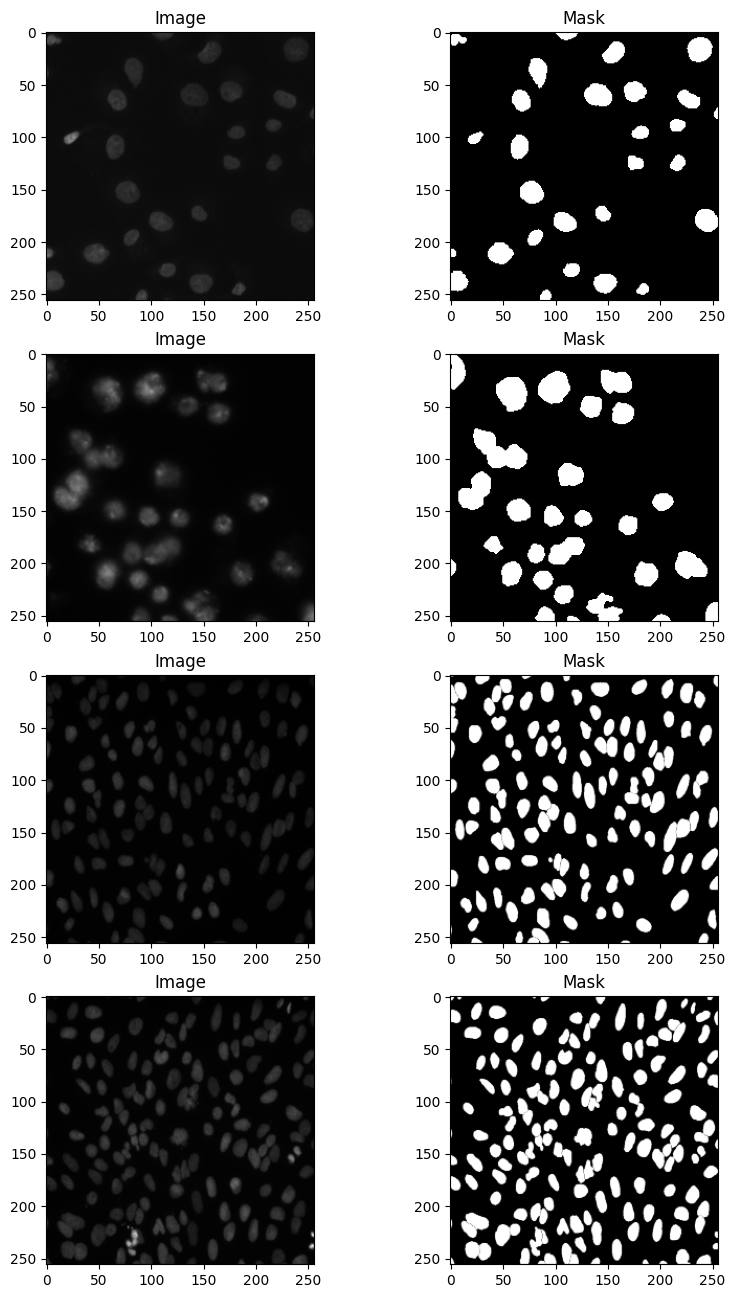

In [12]:
#no
plt.figure(figsize=(20, 16))

# take random 4 images
x, y = 4, 4
for i in range(y):
    index = random.randint(0, len(x_train))
    plt.subplot(y, x, i * x + 1)
    plt.imshow(x_train[index])
    plt.title('Image')

    plt.subplot(y, x, i * x + 2)
    plt.imshow(y_train[index].squeeze(), cmap='gray')
    plt.title('Mask')

## DATASET

In [13]:
import numpy as np
from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

class Nuc_Seg(Dataset):
    def __init__(self, images_np, masks_np):
        self.images_np = images_np
        self.masks_np = masks_np
    
    def transform(self, image_np, mask_np):
        ToPILImage = transforms.ToPILImage()
        image = ToPILImage(image_np)
        mask = ToPILImage(mask_np.astype(np.int32))
        
        #image = TF.pad(image, padding = 0, padding_mode = 'reflect')
        #mask = TF.pad(mask, padding = 0, padding_mode = 'reflect')
        
        angle = random.uniform(-10, 10)
        width, height = image.size
        max_dx = 0.1 * width
        max_dy = 0.1 * height
        translations = (np.round(random.uniform(-max_dx, max_dx)), np.round(random.uniform(-max_dy, max_dy)))
        scale = random.uniform(0.8, 1.2)
        shear = random.uniform(-0.5, 0.5)
        #image = TF.affine(image, angle = angle, translate = translations, scale = scale, shear = shear)
        #mask = TF.affine(mask, angle = angle, translate = translations, scale = scale, shear = shear)
        
        image = TF.resize(image, (256, 256))
        mask = TF.resize(mask, (256, 256))
        
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask
        
    def __len__(self):
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]
        mask_np = self.masks_np[idx]
        image, mask = self.transform(image_np, mask_np)
        
        return image, mask    

In [14]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = SEED)
train_dataset = Nuc_Seg(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataset = Nuc_Seg(X_val, Y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)


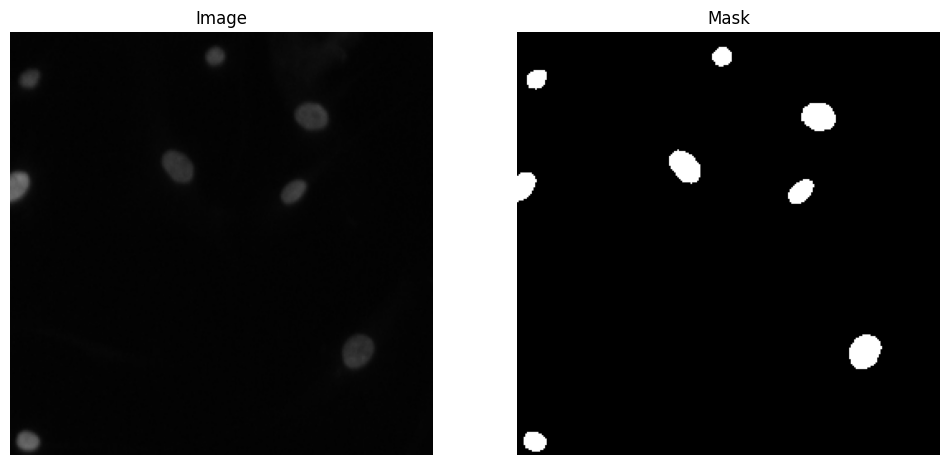

In [15]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def plot_sample(dataset, idx):
    """
    Plots a sample from the dataset.
    
    Args:
        dataset (Dataset): The dataset from which to plot a sample.
        idx (int): The index of the sample to plot.
    """
    image, mask = dataset[idx]

    # Convert tensors to PIL images for plotting
    image = TF.to_pil_image(image)
    mask = TF.to_pil_image(mask)

    # Plot the image and mask
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()

plot_sample(train_dataset, idx=0)



## MODEL

In [16]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNETV1(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNETV1, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        return self.final_conv(x)

In [17]:
class double_convolution(nn.Module):
    """
    This class implements the double convolution block which consists of two 3X3 convolution layers,
    each followed by a ReLU activation function.

    """
    def __init__(self, in_channels, out_channels): # Initialize the class
        super().__init__() # Initialize the parent class

        # First 3X3 convolution layer
        self.first_cnn = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
        self.act1 = nn.ReLU()

        # Second 3X3 convolution layer
        self.second_cnn = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding = 1)
        self.act2 = nn.ReLU()

    # Pass the input through the double convolution block
    def forward(self, x):
        x = self.first_cnn(x)
        x = self.act1(x)
        x = self.act2(self.second_cnn(x))
        return x

# Implement the Downsample block that occurs after each double convolution block
class down_sample(nn.Module):
    """
    This class implements the downsample block which consists of a Max Pooling layer with a kernel size of 2.
    The Max Pooling layer halves the image size reducing the spatial resolution of the feature maps
    while retaining the most important features.
    """
    def __init__(self):
        super().__init__()
        self.max_pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    
    # Pass the input through the downsample block
    def forward(self, x):
        x = self.max_pool(x)
        return x
    
# Implement the UpSample block that occurs in the decoder part of the network
class up_sample(nn.Module):
    """
    This class implements the upsample block which consists of a convolution transpose layer with a kernel size of 2.
    The convolution transpose layer doubles the image size increasing the spatial resolution of the feature maps
    while retaining the learned features.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Convolution transpose layer
        self.up_sample = nn.ConvTranspose2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 2, stride = 2)

    # Pass the input through the upsample block
    def forward(self, x):
        x = self.up_sample(x)
        return x 

# Implement the crop and concatenate block that occurs in the decoder part of the network
# This block concatenates the output of the upsample block with the output of the corresponding downsample block
# The output of the crop and concatenate block is then passed through a double convolution block
class crop_and_concatenate(nn.Module):
    """
    This class implements the crop and concatenate block which combines the output of the upsample block
    with the corresponding features from the contracting path through skip connections,
    allowing the network to recover the fine-grained details lost during downsampling
    and produce a high-resolution output segmentation map.
    """ 
    # def forward(self, upsampled, bypass):
    #     # Crop the feature map from the contacting path to match the size of the upsampled feature map
    #     bypass = torchvision.transforms.functional.center_crop(img = bypass, output_size = [upsampled.shape[2], upsampled.shape[3]]) 
    #     # Concatenate the upsampled feature map with the cropped feature map from the contracting path
    #     x = torch.cat([upsampled, bypass], dim = 1) # Concatenate along the channel dimension
    #     return x
    # Alternatively crop the upsampled feature map to match the size of the feature map from the contracting path
    def forward(self, upsampled, bypass):
        upsampled = torchvision.transforms.functional.resize(img = upsampled, size = bypass.shape[2:], antialias=True)
        x = torch.cat([upsampled, bypass], dim = 1) # Concatenate along the channel dimension
        return x

## Implement the UNet architecture
class UNetV2(nn.Module):
    # in_channels: number of channels in the input image
    # out_channels: number of channels in the output image
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Define the contracting path: convolution blocks followed by downsample blocks
        self.down_conv = nn.ModuleList(double_convolution(in_chans, out_chans) for in_chans, out_chans in
                                       [(in_channels, 64), (64, 128), (128, 256), (256, 512)]) # List of downsample blocks
        
        self.down_samples = nn.ModuleList(down_sample() for _ in range(4))

        # Define the bottleneck layer
        self.bottleneck = double_convolution(in_channels = 512, out_channels = 1024)

        # Define the expanding path: upsample blocks followed by convolution blocks
        self.up_samples = nn.ModuleList(up_sample(in_chans, out_chans) for in_chans, out_chans in
                                        [(1024, 512), (512, 256), (256, 128), (128, 64)]) # List of upsample blocks
        
        self.concat = nn.ModuleList(crop_and_concatenate() for _ in range(4))

        self.up_conv = nn.ModuleList(double_convolution(in_chans, out_chans) for in_chans, out_chans in
                                        [(1024, 512), (512, 256), (256, 128), (128, 64)]) # List of convolution blocks
        
        # Final 1X1 convolution layer to produce the output segmentation map:
        # The primary purpose of 1x1 convolutions is to transform the channel dimension of the feature map,
        # while leaving the spatial dimensions unchanged.
        self.final_conv = nn.Conv2d(in_channels = 64, out_channels = out_channels, kernel_size = 1)

    # Pass the input through the UNet architecture
    def forward(self, x):
        # Pass the input through the contacting path
        skip_connections = [] # List to store the outputs of the downsample blocks
        for down_conv, down_sample in zip(self.down_conv, self.down_samples):
            x = down_conv(x)
            skip_connections.append(x)
            x = down_sample(x)
        
        # Pass the output of the contacting path through the bottleneck layer
        x = self.bottleneck(x)

        # Pass the output of the bottleneck layer through the expanding path
        skip_connections = skip_connections[::-1] # Reverse the list of skip connections
        for up_sample, concat, up_conv in zip(self.up_samples, self.concat, self.up_conv):
            x = up_sample(x)
            x = concat(x, skip_connections.pop(0)) # Remove the first element from the list of skip connections
            x = up_conv(x)
        
        # Pass the output of the expanding path through the final convolution layer
        x = self.final_conv(x)
        return x

METRICS

## Jaccard Index: Measuring Intersection Over Union (IoU)

The **Jaccard Index** is a metric used to compare the similarity between two sets. It calculates the ratio of the size of the intersection of the sets to the size of their union. Mathematically, it's defined as:

$$
J(A, B) = |A ∩ B| / |A ∪ B|
$$

## Jaccard Loss 

The **Jaccard Loss** is derived from the Jaccard index and serves as a loss function during model training. This loss function is particularly useful for image segmentation tasks where the goal is to optimize the model for accurate segmentation. It's defined as:

$$
\mathcal{L}_{\text{Jaccard}}(\mathbf{p}, \mathbf{t}) = 1 - J(\mathbf{p}, \mathbf{t})
$$

where $J(\mathbf{p}, \mathbf{t})$ is the Jaccard index computed between the predicted and true values.


In [18]:
def jaccard(preds, trues, is_average=True):
    num = preds.size(0)
    preds = preds.view(num, -1)
    trues = trues.view(num, -1)

    intersection = (preds * trues).sum(1)
    scores = (intersection + EPS) / ((preds + trues).sum(1) - intersection + EPS)

    score = scores.sum()
    if is_average:
        score /= num
    return torch.clamp(score, 0., 1.)

def jaccard_round(preds, trues, is_average=True):
    preds = torch.round(preds)
    return jaccard(preds, trues, is_average=is_average)


class JaccardLoss(nn.Module):
    def __init__(self, size_average=True):
        super().__init__()
        self.size_average = size_average

    def forward(self, input, target):
        return jaccard(input, target, self.size_average)

## Dice Loss

The Dice Loss is a metric used to evaluate the performance of models in tasks like image segmentation. It focuses on the overlap between the predicted segmentation mask and the ground truth mask, penalizing models that incorrectly classify pixels.

A: Predicted segmentation mask pixels

B: Ground truth segmentation mask pixels

$$
L_Dice(A, B) = 1 - 2 * |A ∩ B| / (|A| + |B|)
$$

In [19]:
def dice_loss(preds, trues, weight=None, is_average=True):
    preds = preds.contiguous().view(preds.size(0), -1)
    trues = trues.contiguous().view(trues.size(0), -1)
    
    if weight is not None:
        weight = weight.view(preds.size(0), -1)
        preds = preds * weight
        trues = trues * weight
    
    intersection = (preds * trues).sum(1)
    scores = (2. * intersection + EPS) / (preds.sum(1) + trues.sum(1) + EPS)
    
    if is_average:
        return scores.mean()
    else:
        return scores

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)

    def forward(self, input, target):
        return dice_loss(input, target, self.weight, self.size_average)

TRAIN 1

In [20]:
def fit(model, epochs, opt, loss_func, train_loader, val_loader, device='cuda', patience=PATIENCE, min_delta=1e-4):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_wts = None
    early_stop_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for image, mask in train_loader:
            image, mask = image.to(device), mask.to(device)

            opt.zero_grad()
            out = model(image.float())

            # apply sigmoid to the output
            #out = torch.sigmoid(out)
            out = (out - out.min()) / (out.max() - out.min())
            mask = (mask - mask.min()) / (mask.max() - mask.min())

            loss = loss_func(out.float(), mask.float())
            loss.backward()
            opt.step()

            train_loss += loss.item()
            train_losses.append(loss.item())

        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for image, mask in val_loader:
                image, mask = image.to(device), mask.to(device)
                out = model(image.float())

                out = (out - out.min()) / (out.max() - out.min())
                mask = (mask - mask.min()) / (mask.max() - mask.min())

                loss = loss_func(out.float(), mask.float())
                val_loss += loss.item()
                val_losses.append(loss.item())

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # Early stopping check for plateau
        if best_val_loss - avg_val_loss > min_delta:
            best_val_loss = avg_val_loss
            best_model_wts = model.state_dict()
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Early stopping check for overfitting
        if avg_train_loss < best_val_loss - min_delta:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping due to plateau or overfitting")
            break

    # Load the best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return train_losses, val_losses

Epoch 1/60, Training Loss: 0.0323, Validation Loss: 0.0017
Epoch 2/60, Training Loss: 0.0004, Validation Loss: 0.0008
Epoch 3/60, Training Loss: 0.0001, Validation Loss: 0.0004
Epoch 4/60, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 5/60, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 6/60, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 7/60, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 8/60, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 9/60, Training Loss: 0.0000, Validation Loss: 0.0000
Early stopping due to plateau or overfitting


In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset

def k_fold_cross_validation(model_class, dataset, k, epochs, loss_fn, lr, batch_size, device='cuda'):
    kfold = KFold(n_splits=k, shuffle=True)

    all_train_losses = []
    all_val_losses = []

    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold+1}/{k}")

        train_subsampler = Subset(dataset, train_ids)
        val_subsampler = Subset(dataset, val_ids)

        train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

        model = model_class().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_losses, val_losses = fit(model, epochs, optimizer, loss_fn, train_loader, val_loader, lr, device)
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

    return all_train_losses, all_val_losses

In [ ]:
model = UNetV2(in_channels=3, out_channels=1).to(device)
loss_fn = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

t_losses, v_losses = fit(model, EPOCHS, optimizer, loss_fn, train_loader, val_loader)

'''
model_class = lambda: UNetV2(in_channels=3, out_channels=1)
loss_fn = DiceLoss()
lr = 0.001
batch_size = 16
epochs = 50
k = 5
'''

In [ ]:
all_train_losses, all_val_losses = k_fold_cross_validation(model_class, dataset, k, epochs, loss_fn, lr, batch_size, device)

# Plotting the losses for each fold
for fold in range(k):
    plt.figure()
    plt.semilogy(all_train_losses[fold], label=f'Training Loss Fold {fold+1}')
    plt.title(f'Training Loss Fold {fold+1}')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log scale)')
    plt.legend()
    plt.show()

    plt.figure()
    plt.semilogy(all_val_losses[fold], label=f'Validation Loss Fold {fold+1}')
    plt.title(f'Validation Loss Fold {fold+1}')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log scale)')
    plt.legend()
    plt.show()

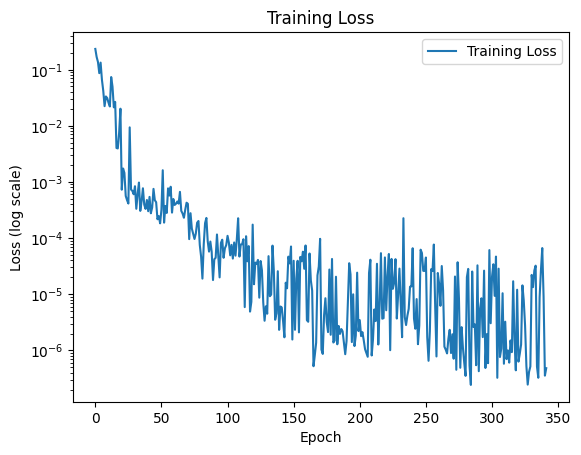

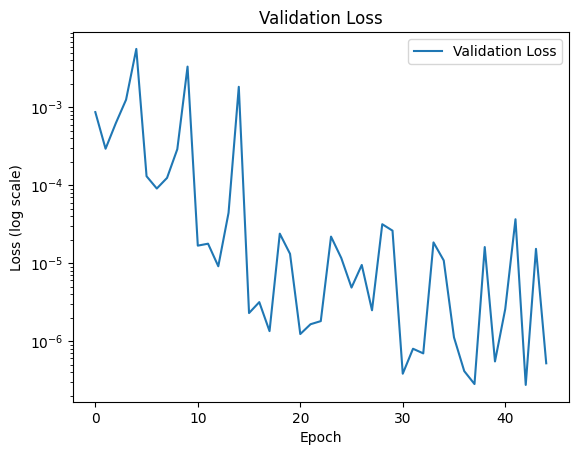

In [21]:
plt.figure()
plt.semilogy(t_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.show()

# Plot validation losses
plt.figure()
plt.semilogy(v_losses, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.show()


72e8c49dea44787114fd191f9e97e260f961c6e7ae4715bc95cc91db8d91a4e3.png


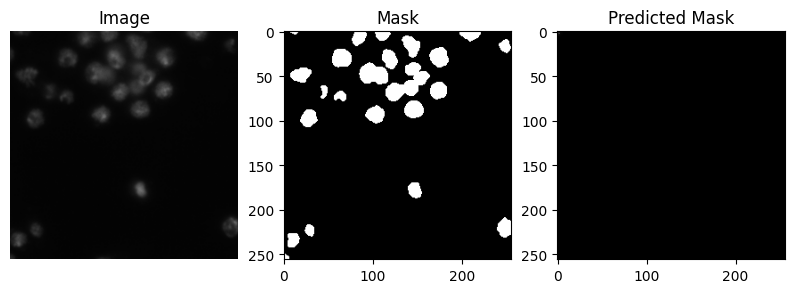

In [22]:
def predict(model, image):
    model.eval()
    image = image.to(device)
    out = model(image.float())
    out = (out - out.min()) / (out.max() - out.min())
    return out

index = random.randint(0, len(val_dataset)- 1)
# draw a random image from the validation set
image, mask = val_dataset[index]
# print id of the image
print(val_images[10])
image = image.unsqueeze(0)
mask = mask.unsqueeze(0)

# predict the mask
predicted_mask = predict(model, image)

# plot the image, mask and predicted mask
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(image.squeeze().permute(1, 2, 0))
plt.title("Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Mask")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze().cpu().detach().numpy(), cmap="gray")
plt.title("Predicted Mask")

plt.show()

In [23]:
def save_checkpoint(state, filename="unet_chckpnt.pth.tar"):
    torch.save(state, filename)

def load_ckp(checkpoint_fpath, model, optimizer):

    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint